In [ ]:
ls

In [ ]:
!unzip QA-Polyp-20220325T005009Z-001.zip

In [23]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
x_dataset = []
y_dataset = []
train_path = 'QA-Polyp/train'

with open(os.path.join(train_path,'train.txt')) as f:
  for line in f.readlines():
    img, label = line.split(' ')
    y_dataset.append(label)
    image = cv.imread(os.path.join(train_path, img))
    res = cv.resize(image,(224, 224), interpolation = cv.INTER_CUBIC)
    x_dataset.append(res)

print(x_dataset[0].shape)
print(y_dataset[0])

In [ ]:
x_array = np.asarray(x_dataset)
y_array = np.asarray(y_dataset)
print(x_array.shape, y_array.shape)

(1062, 224, 224, 3) (1062,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.3, random_state=42)
print(X_train.shape)

(743, 224, 224, 3)


In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                   input_shape=(224, 224, 3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [ ]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,768,385
Trainable params: 1,180,673
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Hyperparameters
LR = 0.001
EPOCHS = 10

Adding weights to loss function to account for datasset imbalance. 

Count

Clear - 830
Blurry - 234

Annotations

clear - 0
Blurry - 1

Weight for blurry = 830/234 = 3.54
weight for clear = 1.00

In [ ]:
# Adding class weights to loss to account for data imbalance


class_weights = { 0:1.00, 1:3.54 }

In [ ]:
resnet_model.compile(optimizer=Adam(lr=LR),loss='binary_crossentropy',metrics=['accuracy'], class_weight = class_weights)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
y_train = np.int_(y_train)
y_train.dtype

dtype('int64')

In [ ]:
hist = resnet_model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
21/21 [==============================] - 17s 479ms/step - loss: 0.3714 - accuracy: 0.8743 - val_loss: 0.1006 - val_accuracy: 0.9333
Epoch 2/10
21/21 [==============================] - 6s 283ms/step - loss: 0.1271 - accuracy: 0.9506 - val_loss: 0.0998 - val_accuracy: 0.9333
Epoch 3/10
21/21 [==============================] - 6s 284ms/step - loss: 0.1110 - accuracy: 0.9551 - val_loss: 0.0944 - val_accuracy: 0.9333
Epoch 4/10
21/21 [==============================] - 6s 284ms/step - loss: 0.0990 - accuracy: 0.9626 - val_loss: 0.1893 - val_accuracy: 0.9200
Epoch 5/10
21/21 [==============================] - 6s 283ms/step - loss: 0.1100 - accuracy: 0.9446 - val_loss: 0.1279 - val_accuracy: 0.9333
Epoch 6/10
21/21 [==============================] - 6s 284ms/step - loss: 0.0778 - accuracy: 0.9716 - val_loss: 0.0944 - val_accuracy: 0.9467
Epoch 7/10
21/21 [==============================] - 6s 284ms/step - loss: 0.0684 - accuracy: 0.9656 - val_loss: 0.0982 - val_accuracy: 0.9600
Epoch

In [ ]:
y_test = np.int_(y_test)
y_test.dtype

dtype('int64')

In [ ]:
loss, acc = resnet_model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.956


In [ ]:
# obtaining predictions 

pred = resnet_model.predict(X_test)

predictions = (resnet_model.predict(X_test) > 0.5).astype("int32")

In [ ]:
# View first few predicitons

print(predictions[0:15])

[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]]


### **PLOTS**

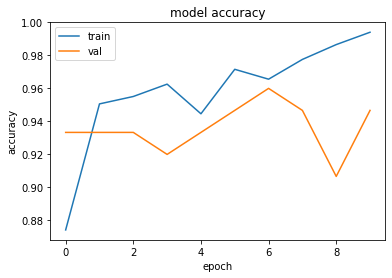

In [ ]:
from matplotlib import pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

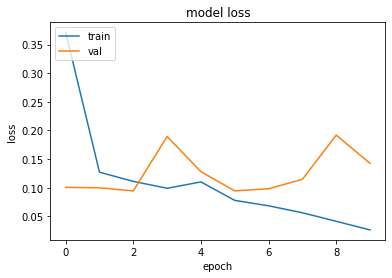

In [ ]:
# Loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Confusion Matrix** 

In [ ]:
res = tf.math.confusion_matrix(y_test, predictions)

Accuracy = (253+52)/(253+52+8+6) = 305/319 = 95.6 %

In [ ]:
print('Confusion_matrix: ',res)

Confusion_matrix:  tf.Tensor(
[[253   6]
 [  8  52]], shape=(2, 2), dtype=int32)


# **ROC**

In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, pred)

auc_keras = auc(fpr, tpr)

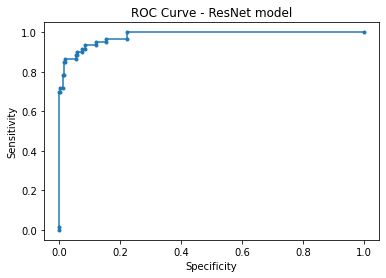

In [ ]:
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.title("ROC Curve - ResNet model")
plt.plot(fpr, tpr, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

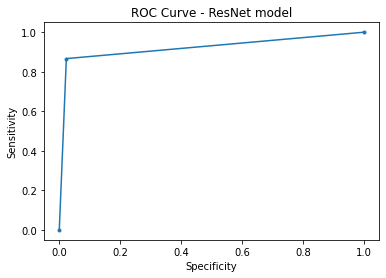

In [ ]:
# You can also pass a discretized version of the predictions to get a staright curve like the 
# one below

fpr, tpr, thresholds = roc_curve(y_test, predictions)

auc_keras = auc(fpr, tpr)
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.title("ROC Curve - ResNet model")
plt.plot(fpr, tpr, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [ ]:
 print('roc_auc_score : ', roc_auc_score(y_test, predictions))

roc_auc_score :  0.9217503217503218
